In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime
from plotly.subplots import make_subplots
import talib
import colored
import os
import yfinance
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
if not os.path.exists("images"):
    os.mkdir("images")

c:\users\homepc\appdata\local\programs\python\python37\lib\site-packages\mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


In [7]:
# os.listdir("../data")

In [26]:
# df = pd.read_csv("../data/XAUUSDH1.csv", parse_dates=[['Date', 'Time']])
df = pd.read_csv("../data/XAUUSD60.csv")
df.tail()
# df = df_raw[:61016]
# df_test = df_raw[61016:]

,Date,Open,High,Low,Close,Volume
86803,2018.12.18,1248.50,1249.78,1247.56,1249.25,10109
86804,2018.12.18,1249.26,1249.71,1248.38,1249.49,7333
86805,2018.12.18,1249.49,1250.39,1248.92,1249.01,8820
86806,2018.12.18,1249.00,1249.24,1246.72,1247.25,10045
86807,2018.12.18,1247.26,1248.05,1246.59,1247.26,8145


In [35]:
from talib import EMA
df['EMA_200'] = talib.EMA(df.Close, timeperiod=200)
df['EMA_50'] = talib.EMA(df.Close, timeperiod=50)
df['DX'] = talib.DX(df.High, df.Low, df.Close, timeperiod=14)
df['RSI'] = talib.RSI(df.Close, timeperiod=14)

# buy signal
df['CDLENGULFING'] = talib.CDLENGULFING(df.Open, df.High, df.Low, df.Close)
df['CDLHAMMER'] = talib.CDLHAMMER(df.Open, df.High, df.Low, df.Close)
df['CDLMORNINGDOJISTAR'] = talib.CDLMORNINGDOJISTAR(df.Open, df.High, df.Low, df.Close)

# sell signal
df['CDLSHOOTINGSTAR'] = talib.CDLSHOOTINGSTAR(df.Open, df.High, df.Low, df.Close)
df['CDLEVENINGSTAR'] = talib.CDLEVENINGSTAR(df.Open, df.High, df.Low, df.Close)
df['CDLINVERTEDHAMMER'] = talib.CDLEVENINGSTAR(df.Open, df.High, df.Low, df.Close)

# df = df.dropna()
print(df.tail())
conditions = [
    (df['CDLENGULFING'] == 1) | (df['CDLHAMMER'] == 1) | (df['CDLMORNINGDOJISTAR'] == 1),
    (df['CDLSHOOTINGSTAR'] == 1) | (df['CDLEVENINGSTAR'] == 1) | (df['CDLINVERTEDHAMMER'] == 1)
    ]
values = ['buy_signal', 'sell_signal']
df['signal'] = np.select(conditions, values)
df.tail()

             Date     Open     High      Low    Close  Volume      EMA_200  \
86803  2018.12.18  1248.50  1249.78  1247.56  1249.25   10109  1240.859369   
86804  2018.12.18  1249.26  1249.71  1248.38  1249.49    7333  1240.945246   
86805  2018.12.18  1249.49  1250.39  1248.92  1249.01    8820  1241.025492   
86806  2018.12.18  1249.00  1249.24  1246.72  1247.25   10045  1241.087427   
86807  2018.12.18  1247.26  1248.05  1246.59  1247.26    8145  1241.148846   

            EMA_50         DX        RSI  CDLENGULFING  CDLHAMMER  \
86803  1243.514940  29.159802  68.488123             0          0   
86804  1243.749256  29.159802  69.135676             0          0   
86805  1243.955559  33.896919  66.205395             0          0   
86806  1244.084753   8.595514  56.713561             0          0   
86807  1244.209273   7.305186  56.751501             0          0   

       CDLMORNINGDOJISTAR  CDLSHOOTINGSTAR  CDLEVENINGSTAR  CDLINVERTEDHAMMER  \
86803                   0          

,Date,Open,High,Low,Close,Volume,EMA_200,EMA_50,DX,RSI,CDLENGULFING,CDLHAMMER,CDLMORNINGDOJISTAR,CDLSHOOTINGSTAR,CDLEVENINGSTAR,CDLINVERTEDHAMMER,signal
86803,2018.12.18,1248.50,1249.78,1247.56,1249.25,10109,1240.859369,1243.514940,29.159802,68.488123,0,0,0,0,0,0,0
86804,2018.12.18,1249.26,1249.71,1248.38,1249.49,7333,1240.945246,1243.749256,29.159802,69.135676,0,0,0,0,0,0,0
86805,2018.12.18,1249.49,1250.39,1248.92,1249.01,8820,1241.025492,1243.955559,33.896919,66.205395,0,0,0,0,0,0,0
86806,2018.12.18,1249.00,1249.24,1246.72,1247.25,10045,1241.087427,1244.084753,8.595514,56.713561,0,0,0,0,0,0,0
86807,2018.12.18,1247.26,1248.05,1246.59,1247.26,8145,1241.148846,1244.209273,7.305186,56.751501,0,0,0,0,0,0,0


In [36]:
#SuperTrend
def ST(df,f,n): #df is the dataframe, n is the period, f is the factor; f=3, n=7 are commonly used.
    #Calculation of ATR
    col_name = f"SuperTrend{f}{n}"
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1)
    df['ATR']=np.nan
    df.loc[n-1,'ATR']=df['TR'][:n-1].mean() #.ix is deprecated from pandas verion- 0.19
    for i in range(n,len(df)):
        df['ATR'][i]=(df['ATR'][i-1]*(n-1)+ df['TR'][i])/n
    
    #Calculation of SuperTrend
    df['Upper Basic']=(df['High']+df['Low'])/2+(f*df['ATR'])
    df['Lower Basic']=(df['High']+df['Low'])/2-(f*df['ATR'])
    df['Upper Band']=df['Upper Basic']
    df['Lower Band']=df['Lower Basic']
    for i in range(n,len(df)):
        if df['Close'][i-1]<=df['Upper Band'][i-1]:
            df['Upper Band'][i]=min(df['Upper Basic'][i],df['Upper Band'][i-1])
        else:
            df['Upper Band'][i]=df['Upper Basic'][i]    
    for i in range(n,len(df)):
        if df['Close'][i-1]>=df['Lower Band'][i-1]:
            df['Lower Band'][i]=max(df['Lower Basic'][i],df['Lower Band'][i-1])
        else:
            df['Lower Band'][i]=df['Lower Basic'][i]   
    df[col_name]=np.nan
    for i in df[col_name]:
        if df['Close'][n-1]<=df['Upper Band'][n-1]:
            df[col_name][n-1]=df['Upper Band'][n-1]
        elif df['Close'][n-1]>df['Upper Band'][i]:
            df[col_name][n-1]=df['Lower Band'][n-1]
    for i in range(n,len(df)):
        if df[col_name][i-1]==df['Upper Band'][i-1] and df['Close'][i]<=df['Upper Band'][i]:
            df[col_name][i]=df['Upper Band'][i]
        elif  df[col_name][i-1]==df['Upper Band'][i-1] and df['Close'][i]>=df['Upper Band'][i]:
            df[col_name][i]=df['Lower Band'][i]
        elif df[col_name][i-1]==df['Lower Band'][i-1] and df['Close'][i]>=df['Lower Band'][i]:
            df[col_name][i]=df['Lower Band'][i]
        elif df[col_name][i-1]==df['Lower Band'][i-1] and df['Close'][i]<=df['Lower Band'][i]:
            df[col_name][i]=df['Upper Band'][i]
    return df

In [37]:
def get_trend(close_p: float, sp_trend_1: float, sp_trend_2: float, sp_trend_3: float) -> str:
    if close_p > sp_trend_1 and close_p > sp_trend_2 and close_p > sp_trend_3:
        return "Buy"
    if close_p < sp_trend_1 and close_p < sp_trend_2 and close_p < sp_trend_3:
        return "Sell"
    return "No Trend"


def isSupport(df,i):
    support = df['Low'][i] < df['Low'][i-1] and \
        df['Low'][i] < df['Low'][i+1] and \
        df['Low'][i+1] < df['Low'][i+2] and \
        df['Low'][i-1] < df['Low'][i-2]

    return support


def isResistance(df,i):
    resistance = df['High'][i] > df['High'][i-1]  and \
        df['High'][i] > df['High'][i+1] and \
        df['High'][i+1] > df['High'][i+2] and \
        df['High'][i-1] > df['High'][i-2] 

    return resistance


def isFarFromLevel(l, s, levels):
    return np.sum([abs(l-x[1]) < s  for x in levels]) == 0


def calculate_support_registance(start, stop):
    levels = []
    df_new = df.iloc[start:stop].reset_index(drop=True)
    s =  np.mean(df_new['High'] - df_new['Low'])
    for i in range(2,df_new.shape[0]-2):
        if isSupport(df_new,i):
            l = df_new['Low'][i]
            if isFarFromLevel(l, s, levels):
                levels.append((i,l, 'Support'))

        elif isResistance(df_new,i):
            l = df_new['High'][i]
            if isFarFromLevel(l, s, levels):
                levels.append((i,l, 'Resistance'))
    return levels
# def save_result(order_index, scan_index, diff, close_p, levels=None):
#     if scan_index > 200:
#         new_df = df.iloc[order_index-20:scan_index+20]
#         data=[
#             go.Candlestick(x=new_df['Date_Time'], open=new_df['Open'], high=new_df['High'], low=new_df['Low'], close=new_df['Close']),
#             go.Scatter(x=new_df['Date_Time'], y=new_df['SuperTrend312'], mode='lines', name='SuperTrend312'),
#             go.Scatter(x=new_df['Date_Time'], y=new_df['SuperTrend110'], mode='lines', name='SuperTrend110'),
#             go.Scatter(x=new_df['Date_Time'], y=new_df['SuperTrend211'], mode='lines', name='SuperTrend211'),
#             go.Scatter(x=[new_df['Date_Time'].loc[order_index]], y=[new_df['Close'].loc[order_index]], mode='markers'),
#             go.Scatter(x=[new_df['Date_Time'].loc[scan_index]], y=[close_p], mode='markers')
#         ]
#         if levels:
#             for level in levels:
#                 line_color = 'green' if level[2] == 'Resistance' else 'red'
#                 data.append(go.Scatter(x=new_df['Date_Time'][:level[0]], y=[level[1]]*level[0], mode='lines', line_color=line_color, name=f'{level[2]} {level[1]}'))
#         fig = go.Figure(data)
#         fig.update_layout(xaxis_rangeslider_visible=False)
#         fig.write_image(f"images/{scan_index}_{round(diff, 1)}.png")

In [38]:
def save_result(order_index, trend, dx):
    if order_index > 50:
        new_df = df.iloc[order_index-50:order_index+100]
        data=[
            go.Candlestick(x=new_df['Date_Time'], open=new_df['Open'], high=new_df['High'], low=new_df['Low'], close=new_df['Close']),
        ]
        fig = go.Figure(data)
        fig.add_hline(y=df.Close[order_index])
        fig.add_vline(x=df.Date_Time[order_index], line_width=3, line_dash="dash", line_color="green")
        fig.update_layout(xaxis_rangeslider_visible=False)
        fig.write_image(f"images/{order_index}-{trend}-{dx}.png")

In [77]:
# n is the period, f is the factor; f=3, n=7 are commonly used.
# df = ST(df, f=3,n=12)
# df = ST(df, f=1,n=10)
df = ST(df, f=2,n=11)

c:\users\thinhpc\anaconda3\envs\p37\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\thinhpc\anaconda3\envs\p37\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\thinhpc\anaconda3\envs\p37\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\thinhpc\anaconda3\envs\p37\lib\site-packages\ipykern

In [78]:
# df['label'] = np.where(df['SuperTrend312'] > df['Close'], 1, 0)

In [86]:
for file in os.listdir("images"):
    os.remove(f"images/{file}")
X = []
y = []
order_p = None
order_size = None
order_index = None
profit = 0
max_profit = 0
max_loss = 0
num_loss = 0
num_profit = 0
stop_loss = None
all_profit = []
with_ema = True
with_stoploss = True
with_dx = True
dx_threshold = 20
cost = 0.1
lock_back_frame = 14
max_diff = 0
min_diff = 0
threshold = 0.95
waiting_frame = 0
all_max_diff = []
all_min_diff = []
for dfindex, date_time, close_p, high_p, \
    low_p, atr, sp_trend_1, ema_200, dx in zip(df.index, df.Date_Time, df.Close,
                                               df.High, df.Low, df.ATR, df.SuperTrend312, df.EMA, df.DX):
    current_trend = get_trend(close_p, sp_trend_1, sp_trend_1, sp_trend_1)
    if waiting_frame > 0:
        waiting_frame -= 1
    else:
        if current_trend == "Buy":
            if order_size == 'Sell':
                # close sell order if exist
#                 real_price = min([stop_loss, close_p]) if stop_loss else close_p
                real_price = close_p
                diff = order_p - real_price - cost
                profit += diff
                save_result(dfindex, "Close Sell", dx)
                print(f"{date_time} {dfindex} close \x1b[48;5;4m{order_size}\x1b[0m order at price {real_price}, max diff {round(max_diff, 2)} diff {round(diff, 2)}")
                all_profit.append(profit)
                if diff < 0:
                    all_min_diff.append(max_diff)
                    max_loss += diff
                    num_loss += 1
                else:
                    all_max_diff.append(max_diff)
                    max_profit += diff
                    num_profit += 1
                
                # create data frame for predict outcome
#                 if diff < -2:
#                     label = 0
#                     x_train = df.ATR.iloc[order_index-lock_back_frame:order_index].values.flatten().tolist()
#                     if len(x_train) == lock_back_frame:
#                         X.append(x_train)
#                         y.append(label)
#                 elif diff > 2:
#                     label = 1
#                     x_train = df.ATR.iloc[order_index-lock_back_frame:order_index].values.flatten().tolist()
#                     if len(x_train) == lock_back_frame:
#                         X.append(x_train)
#                         y.append(label)

                # save to debug
#                 save_result(order_index, dfindex, diff, real_price)

                # reset flags
                order_p = None
                order_size = None
                stop_loss = None
                order_index = None
                max_diff = 0
            if order_p is None:
                if close_p > ema_200:
    #             x_train = df.RSI.iloc[dfindex-lock_back_frame:dfindex]
    #             if len(x_train) == lock_back_frame:
    #                 proba = model.predict(np.expand_dims(np.array(x_train).reshape(-1, 1), axis=0))
    #                 proba = np.amax(proba)
    #                 if proba > threshold:
        #             if close_p > ema_99:
                        # place a new order
                    save_result(dfindex, "Buy", dx)
                    order_p = close_p
                    order_size = current_trend
                    stop_loss = None
                    order_index = dfindex
                    # print(f"{date_time} {dfindex} new \x1b[48;5;2m{order_size}\x1b[0m order at price {close_p} stop loss {round(stop_loss, 2)}")
        if current_trend == 'Sell':
            if order_size == 'Buy':
                # close buy order if exist
#                 real_price = max([stop_loss, close_p]) if stop_loss else close_p
                real_price = close_p
                diff = real_price - order_p - cost
                profit += diff
                all_profit.append(profit)
                save_result(dfindex, "Close Buy", dx)
                print(f"{date_time} {dfindex} close \x1b[48;5;4m{order_size}\x1b[0m order at price {real_price}, max diff {round(max_diff, 2)} diff {round(diff, 2)}")
                if diff < 0:
                    all_min_diff.append(max_diff)
                    max_loss += diff
                    num_loss += 1
                else:
                    all_max_diff.append(max_diff)
                    max_profit += diff
                    num_profit += 1
                # create data frame for predict outcome
#                 if diff < -2:
#                     label = 0
#                     x_train = df.ATR.iloc[order_index-lock_back_frame:order_index].values.flatten().tolist()
#                     if len(x_train) == lock_back_frame:
#                         X.append(x_train)
#                         y.append(label)
#                 elif diff > 2:
#                     label = 1
#                     x_train = df.ATR.iloc[order_index-lock_back_frame:order_index].values.flatten().tolist()
#                     if len(x_train) == lock_back_frame:
#                         X.append(x_train)
#                     y.append(label)
                    
                # save to debug
    #             save_result(order_index, dfindex, diff, real_price)

                # reset flags
                order_p = None
                order_size = None
                stop_loss = None
                order_index = None
                max_diff = 0
            if order_p is None:
                if close_p < ema_200:
                # place a new order
    #             x_train = df.RSI.iloc[dfindex-lock_back_frame:dfindex]
    #             if len(x_train) == lock_back_frame:
    #                 proba = model.predict(np.expand_dims(np.array(x_train).reshape(-1, 1), axis=0))
    #                 proba = np.amax(proba)
    #                 if proba > threshold:
                    save_result(dfindex, "Sell", dx)
                    order_p = close_p
                    order_size = current_trend
                    stop_loss = None
                    order_index = dfindex
                    # print(f"{date_time} {dfindex} new \x1b[48;5;1m{order_size}\x1b[0m order at price {close_p} stop loss {round(stop_loss, 2)}")

#         if order_size is not None:
#             if order_size == "Buy":
#                 if close_p - order_p < -21:
#                     diff = close_p - order_p
#                     profit += (diff - cost)
#                     all_profit.append(profit)
#                     save_result(dfindex, "Close Buy", dx)
#                     print(f"{date_time} {dfindex} close \x1b[48;5;4m{order_size}\x1b[0m order at price {stop_loss}, max diff {round(max_diff, 2)} diff {round(diff, 2)}")
#                     if diff < 0:
#                         max_loss += diff
#                         num_loss += 1
#                     else:
#                         max_profit += diff
#                         num_profit += 1
#                     # create data frame for predict outcome
#                     if diff < -2:
#                         label = 0
#                         x_train = df.ATR.iloc[order_index-lock_back_frame:order_index].values.flatten().tolist()
#                         if len(x_train) == lock_back_frame:
#                             X.append(x_train)
#                             y.append(label)
#                     elif diff > 2:
#                         label = 1
#                         x_train = df.ATR.iloc[order_index-lock_back_frame:order_index].values.flatten().tolist()
#                         if len(x_train) == lock_back_frame:
#                             X.append(x_train)
#                             y.append(label)

                    # save to debug
#                     save_result(order_index, dfindex, diff, stop_loss)

                    # reset flags
#                     order_p = None
#                     order_size = None
#                     stop_loss = None
#                     order_index = None
#                     max_diff = 0
#                     waiting_frame = 0
#                 if order_p: 
#                     diff = close_p - order_p
#                     if diff > max_diff:
#                         max_diff = diff
#                     if diff < min_diff:
#                         min_diff= diff
#                     if max_diff > 1:
#                         new_stop_loss = order_p + cost
#                         if new_stop_loss > stop_loss:
#                             stop_loss = new_stop_loss
#                             print(f"{date_time} {dfindex} stop loss cost modified at {round(stop_loss, 2)} close price {close_p}")
#                     new_stop_loss = sp_trend_3
#                     if new_stop_loss > stop_loss:
#                         stop_loss = new_stop_loss
#                         print(f"{date_time} {dfindex} stop loss atr modified at {round(stop_loss, 2)} close price {close_p}")

#             if order_size == "Sell":
#                 if order_p - close_p  < -21:
#                     diff = order_p - close_p 
#                     profit += (diff - cost)
#                     all_profit.append(profit)
#                     save_result(dfindex, "Close Sell", dx)
#                     print(f"{date_time} {dfindex} close \x1b[48;5;4m{order_size}\x1b[0m order at price {stop_loss}, max diff {round(max_diff, 2)} diff {round(diff, 2)}")
#                     if diff < 0:
#                         max_loss += diff
#                         num_loss += 1
#                     else:
#                         max_profit += diff
#                         num_profit += 1

#                     #save to debug
#                     #save_result(order_index, dfindex, diff, stop_loss)

#                     # reset flags
#                     order_p = None
#                     order_size = None
#                     stop_loss = None
#                     order_index = None
#                     max_diff = 0
#                     waiting_frame = 0
#                 if order_p: 
#     #                 stop_loss = sp_trend_3
#                     diff = order_p - close_p 
#                     if diff > max_diff:
#                         max_diff = diff
#                     if diff < min_diff:
#                         min_diff= diff
#                     if max_diff > 1:
#                         new_stop_loss = order_p - cost
#                         if new_stop_loss < stop_loss:
#                             stop_loss = new_stop_loss
#                             print(f"{date_time} {dfindex} stop loss cost modified at {round(stop_loss, 2)} close price {close_p}")
#                     new_stop_loss = sp_trend_3
#                     if new_stop_loss < stop_loss:
#                         stop_loss = new_stop_loss
#                         print(f"{date_time} {dfindex} stop loss atr modified at {round(stop_loss, 2)} close price {close_p}")

            # modify stoploss
            # check stop loss
    #         if order_size == "Buy" and (high_p - order_p) > 1 and order_p + cost > stop_loss:
    #             stop_loss = order_p + cost
    #             print(f"{date_time} {dfindex} stop loss modified at {round(stop_loss, 2)} difff {round((close_p - order_p), 2)}")
    #         elif order_size == "Sell" and (order_p - low_p) > 1 and order_p - cost < stop_loss:
    #             stop_loss = order_p - cost
    #             print(f"{date_time} {dfindex} stop loss modified at {round(stop_loss, 2)} difff {round((order_p - close_p), 2)}")

#             levels = calculate_support_registance(dfindex - 70, dfindex)
#             if len(levels) >= 2:
#                 support = np.amin([x[1] for x in levels[-2:]])
#                 registance = np.amax([x[1] for x in levels[-2:]])
#                 if order_size == "Buy" and (stop_loss is None or support > stop_loss) and close_p < registance < order_p:
#                     # modify stop loss of the sell order
#                     stop_loss = support
#                     print(f"{date_time} {dfindex} stop loss support modified at {round(stop_loss, 2)} close price {close_p}")
#                 elif order_size == "Sell" and (stop_loss is None or registance < stop_loss) and close_p < registance < order_p:
#                     # modify stop loss of the sell order
#                     stop_loss = registance
#                     print(f"{date_time} {dfindex} stop loss registance modified at {round(stop_loss, 2)} close price {close_p}")
print(f"total trade: {len(all_profit)} avg loss: {max_loss/num_loss} / {num_loss} avg profit {max_profit/num_profit} / {num_profit}")
print(f"total loss: {max_loss} total profit {max_profit} real profit {profit}")
print(f"all max diff avg {sum(all_max_diff) / len(all_max_diff)}")
print(f"all min diff avg {sum(all_min_diff) / len(all_min_diff)}")

2017.06.14 10:45 222 close Buy order at price 1267.03, max diff 0 diff -2.93
2017.06.14 15:30 241 close Sell order at price 1272.94, max diff 0 diff -6.46
2017.06.14 21:00 263 close Buy order at price 1271.6, max diff 0 diff -1.44
2017.06.16 09:15 400 close Sell order at price 1254.5, max diff 0 diff 12.45
2017.06.19 15:00 515 close Sell order at price 1252.54, max diff 0 diff 1.73
2017.06.20 08:45 582 close Sell order at price 1246.03, max diff 0 diff 2.12
2017.06.21 02:30 649 close Sell order at price 1245.15, max diff 0 diff 0.14
2017.06.21 12:45 690 close Sell order at price 1247.36, max diff 0 diff -2.44
2017.06.21 15:15 700 close Buy order at price 1243.37, max diff 0 diff -4.09
2017.06.21 18:00 711 close Sell order at price 1246.27, max diff 0 diff -3.0
2017.06.22 12:45 782 close Buy order at price 1251.45, max diff 0 diff 4.88
2017.06.22 20:15 812 close Buy order at price 1248.65, max diff 0 diff -3.72
2017.06.23 01:00 827 close Sell order at price 1251.41, max diff 0 diff -2.8

2017.09.05 10:30 5618 close Buy order at price 1333.43, max diff 0 diff -2.26
2017.09.05 16:30 5642 close Sell order at price 1334.9, max diff 0 diff -6.2
2017.09.06 06:30 5694 close Buy order at price 1338.06, max diff 0 diff 3.06
2017.09.06 19:45 5747 close Buy order at price 1333.32, max diff 0 diff -7.11
2017.09.07 08:30 5794 close Sell order at price 1336.18, max diff 0 diff -2.96
2017.09.08 11:45 5899 close Buy order at price 1351.53, max diff 0 diff 15.25
2017.09.11 12:00 5992 close Sell order at price 1338.43, max diff 0 diff 5.65
2017.09.12 09:15 6073 close Sell order at price 1327.36, max diff 0 diff 7.89
2017.09.12 15:15 6097 close Sell order at price 1328.56, max diff 0 diff -4.89
2017.09.13 16:00 6192 close Buy order at price 1330.83, max diff 0 diff -1.18
2017.09.14 10:30 6262 close Sell order at price 1324.05, max diff 0 diff 6.68
2017.09.14 15:45 6283 close Sell order at price 1324.67, max diff 0 diff -3.88
2017.09.15 07:15 6341 close Buy order at price 1329.4, max diff

2017.12.04 02:00 11374 close Buy order at price 1273.97, max diff 0 diff -9.0
2017.12.04 17:15 11435 close Sell order at price 1276.09, max diff 0 diff -2.22
2017.12.05 15:30 11516 close Buy order at price 1274.55, max diff 0 diff -2.12
2017.12.06 08:45 11577 close Sell order at price 1267.67, max diff 0 diff 6.78
2017.12.08 04:15 11735 close Sell order at price 1248.96, max diff 0 diff 16.72
2017.12.08 15:15 11779 close Sell order at price 1248.16, max diff 0 diff -0.96
2017.12.12 04:45 11913 close Sell order at price 1244.48, max diff 0 diff 4.42
2017.12.12 20:15 11975 close Sell order at price 1241.68, max diff 0 diff 2.57
2017.12.13 16:30 12048 close Sell order at price 1245.71, max diff 0 diff -3.97
2017.12.14 11:15 12115 close Buy order at price 1255.52, max diff 0 diff 9.71
2017.12.14 16:30 12136 close Buy order at price 1254.48, max diff 0 diff -2.27
2017.12.15 17:45 12229 close Buy order at price 1256.06, max diff 0 diff 0.03
2017.12.18 08:00 12278 close Sell order at price 12

2018.02.27 02:45 16554 close Sell order at price 1335.12, max diff 0 diff -2.82
2018.02.27 06:15 16568 close Buy order at price 1332.41, max diff 0 diff -2.81
2018.02.28 11:30 16681 close Sell order at price 1320.11, max diff 0 diff 12.2
2018.02.28 19:00 16711 close Sell order at price 1320.48, max diff 0 diff -3.77
2018.03.01 15:45 16790 close Sell order at price 1310.36, max diff 0 diff 4.94
2018.03.01 21:45 16814 close Sell order at price 1316.12, max diff 0 diff -12.02
2018.03.02 18:45 16894 close Buy order at price 1318.19, max diff 0 diff 0.63
2018.03.05 13:30 16965 close Buy order at price 1324.2, max diff 0 diff -0.6
2018.03.06 02:15 17012 close Sell order at price 1322.1, max diff 0 diff -0.93
2018.03.06 09:15 17040 close Buy order at price 1321.05, max diff 0 diff -1.15
2018.03.06 11:45 17050 close Sell order at price 1324.24, max diff 0 diff -3.29
2018.03.06 19:45 17082 close Buy order at price 1332.93, max diff 0 diff 8.59
2018.03.07 03:45 17110 close Buy order at price 133

2018.05.08 19:00 21121 close Sell order at price 1314.18, max diff 0 diff -3.57
2018.05.09 04:00 21153 close Buy order at price 1311.51, max diff 0 diff -2.77
2018.05.09 14:15 21194 close Sell order at price 1309.96, max diff 0 diff 1.45
2018.05.10 10:00 21269 close Buy order at price 1312.01, max diff 0 diff -0.5
2018.05.10 12:30 21279 close Sell order at price 1315.65, max diff 0 diff -3.74
2018.05.11 08:30 21355 close Buy order at price 1318.69, max diff 0 diff 2.94
2018.05.11 17:30 21391 close Buy order at price 1322.24, max diff 0 diff 1.19
2018.05.14 03:30 21427 close Sell order at price 1321.79, max diff 0 diff -3.81
2018.05.14 07:15 21442 close Buy order at price 1319.44, max diff 0 diff -2.45
2018.05.16 05:15 21618 close Sell order at price 1294.17, max diff 0 diff 25.03
2018.05.16 19:45 21676 close Sell order at price 1291.67, max diff 0 diff 1.4
2018.05.17 17:15 21758 close Sell order at price 1290.24, max diff 0 diff 0.26
2018.05.18 10:00 21821 close Sell order at price 129

2018.07.20 04:15 25911 close Buy order at price 1219.7, max diff 0 diff -8.11
2018.07.20 07:45 25925 close Sell order at price 1221.89, max diff 0 diff -2.29
2018.07.23 08:30 26020 close Buy order at price 1230.99, max diff 0 diff 7.05
2018.07.24 10:00 26118 close Sell order at price 1222.86, max diff 0 diff 3.51
2018.07.24 18:45 26153 close Buy order at price 1224.34, max diff 0 diff -2.26
2018.07.25 04:15 26187 close Sell order at price 1226.66, max diff 0 diff -2.42
2018.07.25 06:00 26194 close Buy order at price 1223.84, max diff 0 diff -2.92
2018.07.25 08:30 26204 close Sell order at price 1226.53, max diff 0 diff -2.79
2018.07.25 17:15 26239 close Buy order at price 1229.73, max diff 0 diff 3.1
2018.07.26 07:00 26290 close Buy order at price 1231.02, max diff 0 diff -1.7
2018.07.27 15:30 26416 close Sell order at price 1222.02, max diff 0 diff 6.79
2018.07.27 22:15 26443 close Buy order at price 1222.64, max diff 0 diff -2.87
2018.07.30 12:30 26496 close Sell order at price 1222.

2018.09.20 18:30 29994 close Buy order at price 1203.37, max diff 0 diff -1.36
2018.09.21 11:00 30056 close Buy order at price 1207.82, max diff 0 diff 0.12
2018.09.21 17:15 30081 close Sell order at price 1200.2, max diff 0 diff 4.93
2018.09.24 09:45 30143 close Sell order at price 1197.44, max diff 0 diff -1.65
2018.09.24 21:00 30188 close Buy order at price 1199.26, max diff 0 diff -2.06
2018.09.25 09:45 30235 close Sell order at price 1200.2, max diff 0 diff -1.04
2018.09.26 03:45 30303 close Buy order at price 1200.11, max diff 0 diff -0.19
2018.09.26 06:00 30312 close Sell order at price 1202.13, max diff 0 diff -2.12
2018.09.26 09:15 30325 close Buy order at price 1200.46, max diff 0 diff -1.77
2018.09.26 21:45 30375 close Sell order at price 1198.16, max diff 0 diff 2.2
2018.09.27 09:00 30416 close Buy order at price 1195.52, max diff 0 diff -3.05
2018.09.28 12:45 30523 close Sell order at price 1184.53, max diff 0 diff 10.89
2018.09.28 15:45 30535 close Sell order at price 118

2018.12.11 06:15 35253 close Sell order at price 1246.44, max diff 0 diff -2.75
2018.12.11 13:00 35280 close Buy order at price 1246.71, max diff 0 diff 0.17
2018.12.12 03:30 35334 close Sell order at price 1245.75, max diff 0 diff -1.51
2018.12.12 08:15 35353 close Buy order at price 1243.12, max diff 0 diff -2.73
2018.12.12 10:30 35362 close Sell order at price 1244.32, max diff 0 diff -1.3
2018.12.13 11:15 35457 close Buy order at price 1244.68, max diff 0 diff -0.06
2018.12.14 18:00 35576 close Sell order at price 1238.65, max diff 0 diff 5.93
2018.12.17 09:15 35633 close Sell order at price 1238.34, max diff 0 diff -1.96
2018.12.18 08:00 35720 close Buy order at price 1246.58, max diff 0 diff 6.55
2018.12.18 14:45 35747 close Buy order at price 1247.25, max diff 0 diff -0.77
2018.12.19 08:15 35813 close Buy order at price 1249.59, max diff 0 diff -0.48
2018.12.19 19:30 35858 close Buy order at price 1252.69, max diff 0 diff 1.9
2018.12.20 09:15 35909 close Sell order at price 1247

2019.02.15 17:15 39499 close Buy order at price 1315.69, max diff 0 diff 3.09
2019.02.18 07:45 39553 close Buy order at price 1322.76, max diff 0 diff 2.24
2019.02.19 03:30 39613 close Buy order at price 1324.47, max diff 0 diff -0.5
2019.02.20 06:00 39715 close Buy order at price 1343.19, max diff 0 diff 18.04
2019.02.20 21:00 39775 close Buy order at price 1339.16, max diff 0 diff -5.3
2019.02.22 03:00 39887 close Sell order at price 1326.03, max diff 0 diff 10.5
2019.02.22 15:15 39936 close Sell order at price 1326.21, max diff 0 diff -2.21
2019.02.22 21:45 39962 close Buy order at price 1327.8, max diff 0 diff -2.44
2019.02.25 03:30 39981 close Sell order at price 1330.5, max diff 0 diff -2.8
2019.02.25 09:15 40004 close Buy order at price 1329.34, max diff 0 diff -1.26
2019.02.25 13:30 40021 close Sell order at price 1330.95, max diff 0 diff -1.71
2019.02.25 15:15 40028 close Buy order at price 1326.97, max diff 0 diff -4.08
2019.02.25 15:45 40030 close Sell order at price 1330.96

2019.04.25 19:30 43909 close Buy order at price 1276.88, max diff 0 diff 0.66
2019.04.26 15:15 43984 close Buy order at price 1279.27, max diff 0 diff -0.4
2019.04.29 09:15 44052 close Buy order at price 1284.12, max diff 0 diff 1.47
2019.04.29 15:15 44076 close Sell order at price 1283.22, max diff 0 diff -1.89
2019.04.29 16:00 44079 close Buy order at price 1280.16, max diff 0 diff -3.16
2019.04.30 03:30 44121 close Sell order at price 1281.42, max diff 0 diff -1.36
2019.04.30 09:30 44145 close Buy order at price 1281.99, max diff 0 diff 0.47
2019.04.30 15:15 44168 close Buy order at price 1283.48, max diff 0 diff -1.25
2019.04.30 18:30 44181 close Sell order at price 1284.25, max diff 0 diff -2.61
2019.05.01 04:45 44218 close Buy order at price 1281.53, max diff 0 diff -2.82
2019.05.01 10:30 44241 close Sell order at price 1280.86, max diff 0 diff 0.57
2019.05.01 19:15 44276 close Buy order at price 1280.43, max diff 0 diff -1.71
2019.05.01 21:00 44283 close Sell order at price 1285

2019.07.12 04:30 48970 close Sell order at price 1409.13, max diff 0 diff 0.78
2019.07.12 12:00 49000 close Buy order at price 1406.98, max diff 0 diff -4.69
2019.07.12 16:30 49018 close Sell order at price 1409.51, max diff 0 diff -2.63
2019.07.15 04:00 49060 close Buy order at price 1412.54, max diff 0 diff 2.93
2019.07.15 15:30 49106 close Buy order at price 1411.38, max diff 0 diff -3.51
2019.07.15 22:45 49135 close Sell order at price 1415.15, max diff 0 diff -3.87
2019.07.16 04:00 49152 close Buy order at price 1411.66, max diff 0 diff -3.59
2019.07.16 20:00 49216 close Sell order at price 1411.84, max diff 0 diff -0.28
2019.07.17 14:45 49287 close Sell order at price 1404.7, max diff 0 diff -1.7
2019.07.18 05:00 49340 close Buy order at price 1422.38, max diff 0 diff 12.43
2019.07.18 17:30 49390 close Sell order at price 1422.86, max diff 0 diff -6.58
2019.07.19 09:30 49450 close Buy order at price 1439.43, max diff 0 diff 16.47
2019.07.19 17:15 49481 close Buy order at price 14

2019.09.18 21:00 53449 close Buy order at price 1497.4, max diff 0 diff -3.45
2019.09.19 08:30 53491 close Sell order at price 1497.05, max diff 0 diff 0.25
2019.09.19 18:15 53530 close Buy order at price 1497.61, max diff 0 diff -1.15
2019.09.20 04:30 53567 close Sell order at price 1501.72, max diff 0 diff -4.21
2019.09.20 14:30 53607 close Buy order at price 1500.0, max diff 0 diff -1.82
2019.09.20 17:30 53619 close Sell order at price 1504.19, max diff 0 diff -4.29
2019.09.24 08:00 53765 close Buy order at price 1519.57, max diff 0 diff 15.28
2019.09.24 16:00 53797 close Buy order at price 1518.46, max diff 0 diff -5.14
2019.09.25 05:30 53847 close Buy order at price 1528.78, max diff 0 diff 5.04
2019.09.26 07:45 53948 close Sell order at price 1509.83, max diff 0 diff 9.7
2019.09.26 16:00 53981 close Sell order at price 1509.4, max diff 0 diff -2.58
2019.09.27 19:15 54086 close Sell order at price 1497.63, max diff 0 diff 5.82
2019.10.01 12:30 54243 close Sell order at price 1467.

2019.11.26 17:30 57943 close Sell order at price 1459.6, max diff 0 diff -4.22
2019.11.27 05:15 57986 close Buy order at price 1459.0, max diff 0 diff -0.7
2019.11.28 01:15 58062 close Sell order at price 1456.98, max diff 0 diff 1.92
2019.11.28 14:30 58115 close Buy order at price 1455.04, max diff 0 diff -2.62
2019.11.29 03:30 58148 close Sell order at price 1457.22, max diff 0 diff -2.28
2019.11.29 10:45 58177 close Buy order at price 1456.4, max diff 0 diff -0.92
2019.11.29 17:00 58202 close Sell order at price 1460.06, max diff 0 diff -3.76
2019.12.02 02:00 58222 close Buy order at price 1460.35, max diff 0 diff 0.19
2019.12.02 13:00 58266 close Sell order at price 1458.33, max diff 0 diff -1.75
2019.12.04 11:00 58442 close Buy order at price 1475.13, max diff 0 diff 16.7
2019.12.05 09:30 58528 close Buy order at price 1475.1, max diff 0 diff -2.64
2019.12.05 16:15 58555 close Buy order at price 1473.54, max diff 0 diff -4.98
2019.12.05 18:15 58563 close Sell order at price 1478.4

2020.02.11 15:15 62756 close Sell order at price 1571.16, max diff 0 diff -2.19
2020.02.11 17:15 62764 close Buy order at price 1567.68, max diff 0 diff -3.58
2020.02.12 12:15 62836 close Sell order at price 1566.67, max diff 0 diff 0.91
2020.02.14 05:15 62992 close Buy order at price 1574.02, max diff 0 diff 5.82
2020.02.17 09:45 63102 close Buy order at price 1580.16, max diff 0 diff 0.19
2020.02.17 20:00 63143 close Buy order at price 1579.31, max diff 0 diff -2.9
2020.02.19 15:30 63294 close Buy order at price 1604.75, max diff 0 diff 19.76
2020.02.20 03:00 63336 close Buy order at price 1606.7, max diff 0 diff -2.33
2020.02.24 15:00 63568 close Buy order at price 1676.01, max diff 0 diff 65.33
2020.02.25 10:30 63642 close Sell order at price 1649.32, max diff 0 diff -5.47
2020.02.25 21:00 63684 close Buy order at price 1643.47, max diff 0 diff -10.36
2020.02.26 10:30 63734 close Sell order at price 1650.24, max diff 0 diff -6.87
2020.02.26 15:00 63752 close Buy order at price 1642

2020.05.25 10:30 69437 close Sell order at price 1729.12, max diff 0 diff 1.13
2020.05.25 17:45 69466 close Sell order at price 1731.8, max diff 0 diff -7.14
2020.05.26 10:00 69511 close Buy order at price 1728.79, max diff 0 diff -3.11
2020.05.26 15:15 69532 close Sell order at price 1728.72, max diff 0 diff -0.03
2020.05.27 19:00 69639 close Sell order at price 1707.32, max diff 0 diff 10.94
2020.05.28 20:15 69736 close Buy order at price 1716.17, max diff 0 diff 1.5
2020.05.29 02:45 69758 close Sell order at price 1721.76, max diff 0 diff -5.69
2020.05.29 04:00 69763 close Buy order at price 1713.92, max diff 0 diff -7.94
2020.05.29 11:00 69791 close Sell order at price 1722.31, max diff 0 diff -8.49
2020.06.01 11:45 69886 close Buy order at price 1736.64, max diff 0 diff 14.23
2020.06.02 07:30 69961 close Buy order at price 1736.67, max diff 0 diff -4.4
2020.06.02 18:15 70004 close Buy order at price 1733.11, max diff 0 diff -8.27
2020.06.04 05:15 70136 close Sell order at price 17

2020.08.13 21:15 74783 close Buy order at price 1942.77, max diff 0 diff -2.31
2020.08.14 02:00 74798 close Sell order at price 1961.57, max diff 0 diff -18.9
2020.08.14 09:30 74828 close Buy order at price 1944.49, max diff 0 diff -17.18
2020.08.17 09:00 74918 close Sell order at price 1947.59, max diff 0 diff -3.2
2020.08.18 17:00 75042 close Buy order at price 1997.74, max diff 0 diff 50.05
2020.08.19 05:00 75086 close Buy order at price 1993.85, max diff 0 diff -13.82
2020.08.20 05:45 75181 close Sell order at price 1946.49, max diff 0 diff 40.27
2020.08.20 15:30 75220 close Sell order at price 1942.16, max diff 0 diff -7.83
2020.08.21 15:30 75312 close Sell order at price 1931.79, max diff 0 diff 11.02
2020.08.24 16:00 75406 close Buy order at price 1945.49, max diff 0 diff 2.85
2020.08.25 06:30 75460 close Sell order at price 1936.57, max diff 0 diff 6.25
2020.08.26 01:15 75531 close Sell order at price 1930.56, max diff 0 diff -3.36
2020.08.26 16:15 75591 close Sell order at pri

2020.10.22 10:15 79323 close Sell order at price 1919.42, max diff 0 diff -8.23
2020.10.22 14:45 79341 close Buy order at price 1914.22, max diff 0 diff -5.3
2020.10.23 10:30 79416 close Sell order at price 1908.3, max diff 0 diff 5.82
2020.10.23 16:45 79441 close Buy order at price 1903.26, max diff 0 diff -7.58
2020.10.26 12:45 79517 close Sell order at price 1902.82, max diff 0 diff 0.34
2020.10.27 10:15 79599 close Buy order at price 1904.86, max diff 0 diff 0.15
2020.10.27 15:45 79621 close Sell order at price 1905.67, max diff 0 diff -1.63
2020.10.28 03:00 79662 close Buy order at price 1902.89, max diff 0 diff -2.88
2020.10.28 07:30 79680 close Sell order at price 1908.66, max diff 0 diff -5.87
2020.10.28 11:15 79695 close Buy order at price 1902.55, max diff 0 diff -6.21
2020.10.29 08:00 79774 close Sell order at price 1883.23, max diff 0 diff 19.22
2020.10.29 17:15 79811 close Sell order at price 1874.2, max diff 0 diff 2.85
2020.10.30 13:45 79889 close Sell order at price 187

2021.01.06 13:45 84079 close Buy order at price 1945.48, max diff 0 diff -8.8
2021.01.06 22:15 84113 close Sell order at price 1923.02, max diff 0 diff 6.98
2021.01.11 08:15 84333 close Sell order at price 1846.03, max diff 0 diff 71.81
2021.01.11 17:00 84368 close Sell order at price 1847.51, max diff 0 diff -8.14
2021.01.12 15:15 84453 close Buy order at price 1850.22, max diff 0 diff -12.57
2021.01.12 21:15 84477 close Sell order at price 1853.56, max diff 0 diff -3.44
2021.01.13 11:00 84528 close Buy order at price 1849.96, max diff 0 diff -8.93
2021.01.14 16:15 84641 close Sell order at price 1849.37, max diff 0 diff 0.49
2021.01.15 14:00 84724 close Buy order at price 1848.11, max diff 0 diff -7.36
2021.01.18 04:30 84778 close Sell order at price 1829.32, max diff 0 diff 18.69
2021.01.19 14:30 84894 close Buy order at price 1838.92, max diff 0 diff 0.26
2021.01.20 03:00 84940 close Sell order at price 1844.6, max diff 0 diff -5.78
2021.01.20 13:30 84982 close Buy order at price 1

2021.03.23 16:15 89025 close Buy order at price 1734.03, max diff 0 diff -3.85
2021.03.24 05:00 89072 close Sell order at price 1730.87, max diff 0 diff 3.06
2021.03.24 10:15 89093 close Buy order at price 1727.89, max diff 0 diff -5.84
2021.03.24 12:30 89102 close Sell order at price 1734.01, max diff 0 diff -6.22
2021.03.25 10:00 89184 close Buy order at price 1731.3, max diff 0 diff -2.81
2021.03.25 16:15 89209 close Sell order at price 1739.96, max diff 0 diff -8.76
2021.03.25 18:30 89218 close Buy order at price 1731.67, max diff 0 diff -8.39
2021.03.26 12:30 89286 close Sell order at price 1731.27, max diff 0 diff 0.3
2021.03.26 14:00 89292 close Buy order at price 1724.06, max diff 0 diff -7.31
2021.03.26 17:00 89304 close Sell order at price 1729.59, max diff 0 diff -5.63
2021.03.29 04:00 89344 close Buy order at price 1727.59, max diff 0 diff -3.63
2021.03.29 05:00 89348 close Sell order at price 1732.3, max diff 0 diff -4.81
2021.03.29 09:00 89364 close Buy order at price 172

In [87]:
print(f"all diff avg {sum(all_profit) / len(all_profit)}")
print(f"all max diff avg {sum(all_max_diff) / len(all_max_diff)}")
print(f"all min diff avg {sum(all_min_diff) / len(all_min_diff)}")

all diff avg 231.33694610778642
all max diff avg 0.0
all min diff avg 0.0


In [88]:
# Initialize figure with subplots
fig = make_subplots(
    rows=2, cols=1,
    column_widths=[2],
    row_heights=[1, 0.5])
#     specs=[[{"type": "scatter", "colspan": 2}, {"type": "scatter"}],
#            [            None                    , {"type": "bar"}]])
# Add locations bar chart
fig.add_trace(
    go.Bar(x=['total profit', 'total loss'],  y=[max_profit, abs(max_loss)], showlegend=False, 
           text=[f"avg profit {round(max_profit/num_profit, 2)} / {num_profit}", 
                 f"avg loss: {round(max_loss/num_loss, 2)} / {num_loss}"], textposition='auto'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(y=all_profit, showlegend=False),
    row=1, col=1
)
# Set theme, margin, and annotation in layout
fig.update_layout(
    template="plotly_dark",
    margin=dict(r=100, t=25, b=50, l=60),
    annotations=[
        dict(
            text=f"XAUUSD D1 winrate {round(num_profit/len(all_profit)*100, 1)}%",
            showarrow=False,
            xref="paper",
            yref="paper",
            x=0,
            y=0)
    ]
)

In [157]:
# levels = []
# order_index = 400
# scan_index = 600
# df_new = df.iloc[order_index:scan_index].reset_index(drop=True)
# # print(df_new.head())
# # df_new['Date'] = df_new['Date_Time'].apply(mpl_dates.datestr2num)
# s =  np.mean(df_new['High'] - df_new['Low'])
# for i in range(2,df_new.shape[0]-2):
#     if isSupport(df_new,i):
#         l = df_new['Low'][i]
#         if isFarFromLevel(l, s):
#             levels.append((i,l, 'Support'))

#     elif isResistance(df_new,i):
#         l = df_new['High'][i]
#         if isFarFromLevel(l, s):
#             levels.append((i,l, 'Resistance'))
# print(levels)

# data=[
#     go.Candlestick(x=df_new['Date_Time'], open=df_new['Open'], high=df_new['High'], low=df_new['Low'], close=df_new['Close']),
# #     go.Scatter(x=df_new['Date_Time'], y=df_new['SuperTrend312'], mode='lines', name='SuperTrend312'),
# #     go.Scatter(x=df_new['Date_Time'], y=df_new['SuperTrend110'], mode='lines', name='SuperTrend110'),
# #     go.Scatter(x=df_new['Date_Time'], y=df_new['SuperTrend211'], mode='lines', name='SuperTrend211')
# ]
# for level in levels:
#     line_color = 'green' if level[2] == 'Resistance' else 'red'
# #     fig.add_hline(y=level[1], row=level[0], annotation_text=f'{level[0]}{level[2]}', line_color=line_color)
# #     fig.add_vline(x=level[0], line_width=3, line_dash="dash", line_color="green", annotation_text=f'{level[0]}')
# #     fig.add_hrect(y1=level[0])
#     data.append(go.Scatter(x=df_new['Date_Time'][level[0]:], y=[level[1]]*level[0], mode='lines', line_color=line_color, name=f'{level[2]} {level[1]}'))
# fig = go.Figure(data)
# fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()

# Classification

In [264]:
import pandas
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint
from livelossplot import PlotLossesKeras
from sklearn.metrics import plot_confusion_matrix, classification_report
from livelossplot import PlotLossesKeras

In [272]:
from sklearn.model_selection import train_test_split
X_new = np.array(X)
y_new = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.33, random_state=42, stratify=y)
X_train.shape

(250, 14)

In [254]:
# normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [273]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [274]:
num_classes = len(np.unique(y_train))
idx = np.random.permutation(len(X_train))
X_train = X_train[idx]
y_train = y_train[idx]

In [275]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])

In [276]:
epochs = 5000
batch_size = 32

callbacks = [
#     keras.callbacks.ModelCheckpoint(
#         "best_model.h5", save_best_only=True, monitor="val_loss"
#     ),
#     keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
#     ),
    PlotLossesKeras(),
#     keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=0,
)

KeyboardInterrupt: 

In [277]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

124/124 [==============================] - 1s 7ms/step
Test accuracy 0.6048387077546888
Test loss 0.697221198389607


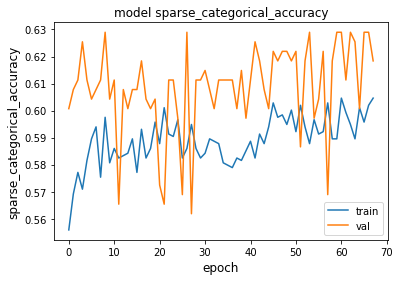

In [278]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [279]:
from sklearn.metrics import classification_report, confusion_matrix
#Confution Matrix and Classification Report
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print('Classification Report')
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))

Confusion Matrix
[[ 0 49]
 [ 0 75]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.60      1.00      0.75        75

    accuracy                           0.60       124
   macro avg       0.30      0.50      0.38       124
weighted avg       0.37      0.60      0.46       124



c:\users\thinhpc\anaconda3\envs\p37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\users\thinhpc\anaconda3\envs\p37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\users\thinhpc\anaconda3\envs\p37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.442


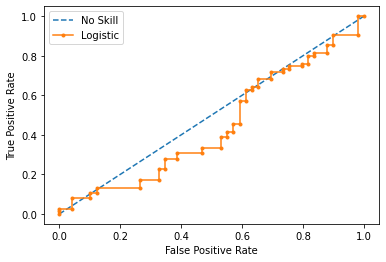

In [280]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# keep probabilities for the positive outcome only
lr_probs = Y_pred[:, 1]
# calculate scores
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [373]:
# model = Sequential()
# model.add(tf.keras.Input(shape=(X_train.shape[1],)))
# model.add(Dense(32))
# model.add(Dense(32))
# model.add(Dense(1))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
# mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

# model.fit(
#     X_train, y_train,
#     epochs=10000,
#     validation_data=(X_test, y_test),
#     callbacks=[PlotLossesKeras(), es, mc],
#     verbose=0,
#     batch_size=32
# )

# # model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)
# # Final evaluation of the model
# scores = model.evaluate(X_test, y_test, verbose=0)
# print(f"Accuracy {scores}")

In [82]:
# clf = svm.SVC(kernel='linear', C=1, random_state=42, probability=True)
# clf.fit(X_train, y_train)
# scores = cross_val_score(clf, X_train, y_train, cv=5)
# print(scores)
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.54822335 0.54822335 0.54822335 0.54591837 0.54591837]
0.55 accuracy with a standard deviation of 0.00


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.487


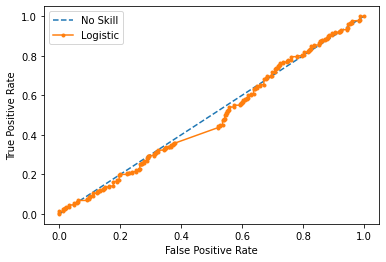

              precision    recall  f1-score   support

           0       0.55      1.00      0.71       265
           1       0.00      0.00      0.00       220

    accuracy                           0.55       485
   macro avg       0.27      0.50      0.35       485
weighted avg       0.30      0.55      0.39       485



c:\users\thinhpc\anaconda3\envs\p37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\users\thinhpc\anaconda3\envs\p37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\users\thinhpc\anaconda3\envs\p37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



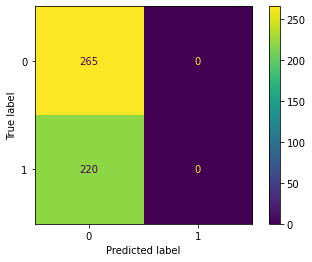

In [83]:
# # predict probabilities
# lr_probs = clf.predict_proba(X_test)
# y_pred = clf.predict(X_test)
# # print(lr_probs)
# keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# # calculate scores
# ns_probs = [0 for _ in range(len(y_test))]
# ns_auc = roc_auc_score(y_test, ns_probs)
# lr_auc = roc_auc_score(y_test, lr_probs)
# # summarize scores
# print('No Skill: ROC AUC=%.3f' % (ns_auc))
# print('Logistic: ROC AUC=%.3f' % (lr_auc))
# # calculate roc curves
# ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
# lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# # plot the roc curve for the model
# pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# # axis labels
# pyplot.xlabel('False Positive Rate')
# pyplot.ylabel('True Positive Rate')
# # show the legend
# pyplot.legend()
# # show the plot
# pyplot.show()
# plot_confusion_matrix(clf, X_test, y_test)  
# print(classification_report(y_test, y_pred))

In [143]:
# generate 2 class dataset
# split into train/test sets
# trainX, testX, trainy, testy = train_test_split(X_new, y_new, test_size=0.5, random_state=2)
# normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
# trainX = scaler.fit_transform(trainX)
# testX = scaler.transform(testX)
# generate a no skill prediction (majority class)
# ns_probs = [0 for _ in range(len(y_test))]
# fit a model
# model = LogisticRegression(solver='lbfgs')
# model.fit(X, y_test)
# predict probabilities
# lr_probs = model.predict_proba(testX)
# # keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# # calculate scores
# ns_auc = roc_auc_score(testy, ns_probs)
# lr_auc = roc_auc_score(testy, lr_probs)
# # summarize scores
# print('No Skill: ROC AUC=%.3f' % (ns_auc))
# print('Logistic: ROC AUC=%.3f' % (lr_auc))
# # calculate roc curves
# ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
# lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# # plot the roc curve for the model
# pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# # axis labels
# pyplot.xlabel('False Positive Rate')
# pyplot.ylabel('True Positive Rate')
# # show the legend
# pyplot.legend()
# # show the plot
# pyplot.show()
